# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [94]:
import pandas as pd
from collections import Counter
from sklearn.base import BaseEstimator

In [7]:
def gini(x):
    l = len(x)
    C = Counter(x)
    P = np.array([C[k]/l for k in C])
    GG = 1 - sum(P ** 2)
    return GG
    
def entropy(x):
    l = len(x)
    C = Counter(x)
    P = np.array([C[k]/l for k in C])
    IG = -sum(P*np.log2(P))
    return IG

def gain(left_y, right_y, criterion):
    left_l = len(left_y)
    right_l = len(right_y)
    total_l = left_l + right_l
    res = criterion(np.concatenate((left_y, right_y))) - left_l / total_l * criterion(left_y) - right_l/total_l * criterion(right_y)
    return res

class DecisionTreeLeaf:
    def __init__(self, y):
        self._C = Counter(y)
        self._l = len(y)
        self.y = self._C.most_common(1)[0][0]
        self.probs = {k: self._C[k]/self._l for k in self._C}

class DecisionTreeNode:
    def __init__(self, X, y, split_dim, split_value, level, left=None, right=None):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        self.level = level
        self.X = X
        self.y = y
    
    def __repr__(self):
        return f'DecisionTreeNode ({self.split_dim=}, {self.split_value=}, {self.level=})'

class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.criterion = {'gini': gini, 'entropy': entropy}.get(criterion)
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X, y):
        if len(Counter(y)) == 1 or len(y) < self.min_samples_leaf or self.max_depth == 1:
            # Критерий для листа: 
            # у всех точек один класс или 
            # достигнут минимум точек для листа или 
            # максимум глубины
            self.root = DecisionTreeLeaf(y)
            return
        
        best_gain, best_thres, best_col = self._best_split(X, y)
        self.root = DecisionTreeNode(X, y, split_dim=best_col, split_value=best_thres, level=1)
        queue = [self.root]
        while queue:
            node = queue.pop()
            left = node.X[:, node.split_dim] < node.split_value
            right = np.logical_not(left)
            left_y = node.y[left]
            right_y = node.y[right]
            
            if len(Counter(left_y)) == 1 or len(left_y) < self.min_samples_leaf or node.level == self.max_depth:
                node.left = DecisionTreeLeaf(left_y)
            else:
                best_gain, best_thres, best_col = self._best_split(node.X[left, :], left_y)
                node.left = DecisionTreeNode(node.X[left, :], left_y, \
                                             split_dim=best_col, split_value=best_thres, level=node.level+1)
                queue.append(node.left)
            
            if len(Counter(right_y)) == 1 or len(right_y) < self.min_samples_leaf or node.level == self.max_depth:
                node.right = DecisionTreeLeaf(right_y)
            else:
                best_gain, best_thres, best_col = self._best_split(node.X[right, :], right_y)
                node.right = DecisionTreeNode(node.X[right, :], right_y, \
                                             split_dim=best_col, split_value=best_thres, level=node.level+1)
                queue.append(node.right)
            
        
    
    def predict_proba(self, X):
        rows, _ = X.shape
        res = []
        for i in range(rows):
            x = X[i, :]
            n = self.root
            while not isinstance(n, DecisionTreeLeaf):
                if x[n.split_dim] < n.split_value:
                    n = n.left
                else:
                    n = n.right
            res.append(n.probs)
        return res
        
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]
    
    def _best_split(self, X, y):
        _, cols = X.shape
        splits = []
        for col in range(cols):
            # Считаем gain по точкам между уникальными значениями по каждому столбцу
            values = np.unique(X[:, col])
            col_split_candidates = [ (values[i] + values[i+1])/2 for i in range(len(values)-1)]

            for split_candidate in col_split_candidates:
                left = X[:, col] < split_candidate
                right = np.logical_not(left)
                y_left = y[left]
                y_right = y[right]
                splits.append((gain(y_left, y_right, self.criterion), split_candidate, col))

        return max(splits)

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [169]:
class RandomForestClassifier(BaseEstimator):
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", 
                 n_estimators=10, n_observations=500):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.n_observations = n_observations
    
    def fit(self, X, y):
        self.X_fit = X
        self.y_fit = y
        self.classes = len(set(y))
        rows, cols = X.shape
        self.trees = []
        self.used_obs = []
        
        while len(self.trees) < self.n_estimators:
            obs = random.choices(population=range(rows), k=self.n_observations)
            
            dtc = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth, 
                                         min_samples_leaf=self.min_samples_leaf)
            try:
                dtc.fit(X[obs, :], y[obs])
                self.trees.append( dtc )
                self.used_obs.append(obs)
            except:
                pass
    
    
    def predict_proba(self, X):
        pred_y = []
        for tree in self.trees:
            pred = tree.predict(X)
            pred_y.append(pred)
        all_pred = np.vstack(pred_y).T
        
        rows, _ = X.shape
        res = np.zeros((rows, self.classes))
        for i in range(rows):
            C = Counter(all_pred[i])
            for j in range(self.classes):
                res[i, j] = C[j] / self.n_estimators
        return res
           
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)
        

In [44]:
spam = pd.read_csv('hw2_data/spam.csv')
y = spam['label'].to_numpy()
X = spam.drop(columns='label').to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [76]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV

In [149]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

In [141]:
X_train_train, X_valid, y_train_train, y_valid = train_test_split(X_train, y_train, 
                                                                  test_size=0.2, random_state=42)
tuned_parameters = {'max_depth': [2, 3, 5, 7],
        'n_estimators': [5, 10, 20, 30, 50, 100]}

res = []
for m_d in tuned_parameters['max_depth']:
    X = RandomForestClassifier(max_depth=m_d, n_estimators=max(tuned_parameters['n_estimators']))
    X.fit(X_train_train, y_train_train)
    for n_e in sorted(tuned_parameters['n_estimators'], reverse=True):
        X.trees = X.trees[:n_e]
        y_pred = X.predict(X_valid)
        auc = roc_auc_score(y_valid, y_pred)
        res.append( (auc, m_d, n_e) )

In [144]:
max(res)

(0.9178440607012036, 7, 30)

In [ ]:
best_forest = RandomForestClassifier(max_depth=7, n_estimators=30)
best_forest.fit(X_train, y_train)
y_pred = best_forest.predict(X_test)

In [148]:
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'AUC: {roc_auc_score(y_test, y_pred):.2f}')

Accuracy: 0.93
AUC: 0.92


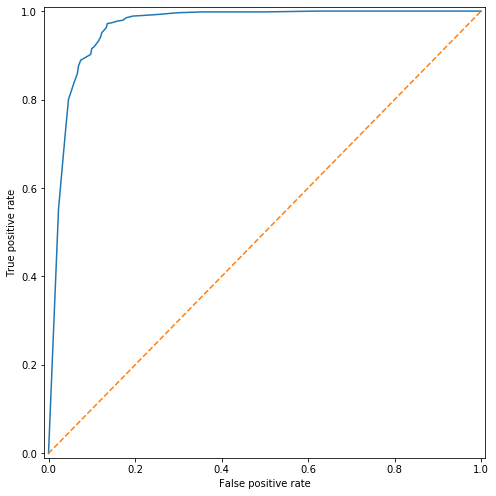

In [152]:
probs = best_forest.predict_proba(X_test)
rows, cols = probs.shape
probs_dicts = [{j: probs[i, j] for j in range(cols)}for i in range(rows)]
plot_roc_curve(y_test, probs_dicts)

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [203]:
def oob_error(rfc):
    oob_errors = 0
    for i, x in enumerate(rfc.X_fit):
        y = []
        for j, tree in enumerate(rfc.trees):
            if i not in rfc.used_obs[j]:
                y.append(tree.predict(np.array([x]))[0])
        if rfc.y_fit[i] != Counter(y).most_common(1)[0][0]:
            oob_errors += 1
    
    return(oob_errors/len(rfc.y_fit))   

def feature_importance(rfc):
    err_oob = oob_error(rfc)
    X_orig = copy.copy(rfc.X_fit)
    imp_j = []
    _, cols = rfc.X_fit.shape
    for j in range(cols):
        X_j = copy.copy(X_orig)
        random.shuffle(X_j[:, j])
        rfc.X_fit = X_j
        err_j = oob_error(rfc)
        imp_j.append(err_j - err_oob)
    return imp_j

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [204]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
y_pred = rfc.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))
print("Importance:", feature_importance(rfc))

Accuracy: 1.0
Importance: [0.0, 0.0, 0.186, 0.191, 0.43, 0.0]


Проверьте, какие признаки важны для датасетов cancer и spam?

_Ваш ответ_

In [221]:
spam = pd.read_csv('hw2_data/spam.csv')
spam_y = spam['label'].to_numpy()
spam_X = spam.drop(columns='label').to_numpy()
spam_X_train, spam_X_test, spam_y_train, spam_y_test = train_test_split(spam_X, spam_y, test_size=0.2, random_state=42)

In [216]:
rfc = RandomForestClassifier(max_depth=7, n_estimators=30)
rfc.fit(spam_X, spam_y)
importance = feature_importance(rfc)
names = list(spam.columns)
names.remove('label')
mi = most_important_features(importance, names, k=10)
print(' '.join(mi))

array(['word_freq_remove', 'char_freq_!', 'word_freq_hp', 'char_freq_$',
       'capital_run_length_average', 'word_freq_free',
       'capital_run_length_total', 'word_freq_our', 'word_freq_edu',
       'word_freq_money'], dtype='<U26')

In [220]:
cancer = pd.read_csv('hw2_data/cancer.csv')
cancer_y = (cancer['label'].to_numpy() == 'M').astype(int)
cancer_X = cancer.drop(columns='label').to_numpy()
cancer_X_train, cancer_X_test, cancer_y_train, cancer_y_test = train_test_split(cancer_X, cancer_y, test_size=0.2, random_state=42)

In [218]:
rfc = RandomForestClassifier(max_depth=7, n_estimators=30)
rfc.fit(cancer_X, cancer_y)

In [219]:
importance = feature_importance(rfc)
names = list(cancer.columns)
names.remove('label')
mi = most_important_features(importance, names, k=10)
print(' '.join(mi))

28 24 14 22 23 2 8 27 4 25


### Задание 5 (2 балла)
В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов

In [222]:
import lightgbm
import catboost
import xgboost

Также, как и реализованный нами RandomForest, примените модели для наших датасетов.

Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)). 

Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

# lightgbm

In [233]:
%%time
L = lightgbm.LGBMClassifier()
L.fit(spam_X_train, spam_y_train)

CPU times: user 1.85 s, sys: 11.9 ms, total: 1.86 s
Wall time: 547 ms


LGBMClassifier()

In [224]:
L_y_pred = L.predict(spam_X_test)
print(f'Accuracy: {accuracy_score(spam_y_test, L_y_pred):.2f}')
print(f'AUC: {roc_auc_score(spam_y_test, L_y_pred):.2f}')

Accuracy: 0.97
AUC: 0.96


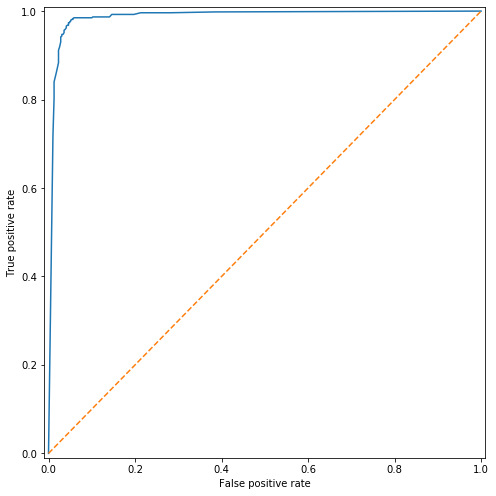

In [226]:
probs = L.predict_proba(spam_X_test)
rows, cols = probs.shape
probs_dicts = [{j: probs[i, j] for j in range(cols)}for i in range(rows)]
plot_roc_curve(spam_y_test, probs_dicts)

In [236]:
%%time
L.fit(cancer_X_train, cancer_y_train)

CPU times: user 654 ms, sys: 23.9 ms, total: 678 ms
Wall time: 209 ms


LGBMClassifier()

In [228]:
L_y_pred = L.predict(cancer_X_test)
print(f'Accuracy: {accuracy_score(cancer_y_test, L_y_pred):.2f}')
print(f'AUC: {roc_auc_score(cancer_y_test, L_y_pred):.2f}')

Accuracy: 0.96
AUC: 0.96


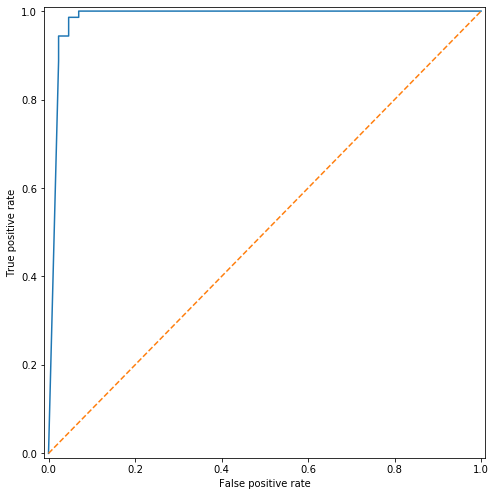

In [229]:
probs = L.predict_proba(cancer_X_test)
rows, cols = probs.shape
probs_dicts = [{j: probs[i, j] for j in range(cols)}for i in range(rows)]
plot_roc_curve(cancer_y_test, probs_dicts)

# catboost

In [230]:
C = catboost.CatBoostClassifier()

In [232]:
%%time
C.fit(spam_X_train, spam_y_train)

Learning rate set to 0.01797
0:	learn: 0.6712954	total: 14.3ms	remaining: 14.3s
1:	learn: 0.6524123	total: 24.6ms	remaining: 12.3s
2:	learn: 0.6338321	total: 33.4ms	remaining: 11.1s
3:	learn: 0.6150818	total: 44.4ms	remaining: 11.1s
4:	learn: 0.5983657	total: 53ms	remaining: 10.5s
5:	learn: 0.5811688	total: 61.2ms	remaining: 10.1s
6:	learn: 0.5632164	total: 69.5ms	remaining: 9.86s
7:	learn: 0.5456946	total: 77.6ms	remaining: 9.63s
8:	learn: 0.5295430	total: 86.6ms	remaining: 9.54s
9:	learn: 0.5151267	total: 94.9ms	remaining: 9.39s
10:	learn: 0.5047861	total: 104ms	remaining: 9.31s
11:	learn: 0.4924422	total: 112ms	remaining: 9.19s
12:	learn: 0.4783559	total: 120ms	remaining: 9.09s
13:	learn: 0.4665455	total: 128ms	remaining: 9s
14:	learn: 0.4570336	total: 136ms	remaining: 8.93s
15:	learn: 0.4460645	total: 144ms	remaining: 8.88s
16:	learn: 0.4368568	total: 153ms	remaining: 8.83s
17:	learn: 0.4280305	total: 161ms	remaining: 8.79s
18:	learn: 0.4176713	total: 169ms	remaining: 8.74s
19:	lea

170:	learn: 0.1478432	total: 1.7s	remaining: 8.22s
171:	learn: 0.1474372	total: 1.71s	remaining: 8.22s
172:	learn: 0.1472439	total: 1.72s	remaining: 8.21s
173:	learn: 0.1470967	total: 1.73s	remaining: 8.2s
174:	learn: 0.1468507	total: 1.74s	remaining: 8.18s
175:	learn: 0.1466359	total: 1.74s	remaining: 8.16s
176:	learn: 0.1462496	total: 1.75s	remaining: 8.14s
177:	learn: 0.1458879	total: 1.76s	remaining: 8.12s
178:	learn: 0.1456172	total: 1.77s	remaining: 8.11s
179:	learn: 0.1454436	total: 1.77s	remaining: 8.09s
180:	learn: 0.1452067	total: 1.78s	remaining: 8.07s
181:	learn: 0.1449220	total: 1.79s	remaining: 8.05s
182:	learn: 0.1447111	total: 1.8s	remaining: 8.04s
183:	learn: 0.1444809	total: 1.81s	remaining: 8.02s
184:	learn: 0.1443156	total: 1.82s	remaining: 8s
185:	learn: 0.1441172	total: 1.82s	remaining: 7.99s
186:	learn: 0.1440028	total: 1.83s	remaining: 7.97s
187:	learn: 0.1436040	total: 1.84s	remaining: 7.95s
188:	learn: 0.1432696	total: 1.85s	remaining: 7.93s
189:	learn: 0.1430

338:	learn: 0.1201196	total: 3.35s	remaining: 6.54s
339:	learn: 0.1200361	total: 3.37s	remaining: 6.53s
340:	learn: 0.1198906	total: 3.37s	remaining: 6.52s
341:	learn: 0.1196604	total: 3.38s	remaining: 6.51s
342:	learn: 0.1196382	total: 3.39s	remaining: 6.5s
343:	learn: 0.1195334	total: 3.4s	remaining: 6.49s
344:	learn: 0.1194120	total: 3.41s	remaining: 6.47s
345:	learn: 0.1193171	total: 3.42s	remaining: 6.46s
346:	learn: 0.1192788	total: 3.42s	remaining: 6.45s
347:	learn: 0.1191852	total: 3.43s	remaining: 6.43s
348:	learn: 0.1191209	total: 3.44s	remaining: 6.42s
349:	learn: 0.1190264	total: 3.45s	remaining: 6.41s
350:	learn: 0.1188501	total: 3.46s	remaining: 6.39s
351:	learn: 0.1186529	total: 3.46s	remaining: 6.38s
352:	learn: 0.1185792	total: 3.47s	remaining: 6.37s
353:	learn: 0.1185390	total: 3.48s	remaining: 6.35s
354:	learn: 0.1185009	total: 3.49s	remaining: 6.34s
355:	learn: 0.1183229	total: 3.5s	remaining: 6.33s
356:	learn: 0.1182532	total: 3.51s	remaining: 6.31s
357:	learn: 0.1

501:	learn: 0.1047832	total: 4.79s	remaining: 4.76s
502:	learn: 0.1047549	total: 4.8s	remaining: 4.75s
503:	learn: 0.1047253	total: 4.82s	remaining: 4.74s
504:	learn: 0.1046210	total: 4.83s	remaining: 4.73s
505:	learn: 0.1043975	total: 4.83s	remaining: 4.72s
506:	learn: 0.1043877	total: 4.84s	remaining: 4.71s
507:	learn: 0.1043221	total: 4.85s	remaining: 4.7s
508:	learn: 0.1042915	total: 4.86s	remaining: 4.69s
509:	learn: 0.1042547	total: 4.87s	remaining: 4.68s
510:	learn: 0.1041651	total: 4.88s	remaining: 4.67s
511:	learn: 0.1040421	total: 4.89s	remaining: 4.66s
512:	learn: 0.1040227	total: 4.9s	remaining: 4.65s
513:	learn: 0.1039494	total: 4.91s	remaining: 4.64s
514:	learn: 0.1039242	total: 4.92s	remaining: 4.63s
515:	learn: 0.1037656	total: 4.92s	remaining: 4.62s
516:	learn: 0.1036321	total: 4.93s	remaining: 4.61s
517:	learn: 0.1036208	total: 4.94s	remaining: 4.6s
518:	learn: 0.1035518	total: 4.95s	remaining: 4.59s
519:	learn: 0.1035435	total: 4.96s	remaining: 4.58s
520:	learn: 0.10

663:	learn: 0.0921824	total: 6.24s	remaining: 3.15s
664:	learn: 0.0919808	total: 6.24s	remaining: 3.15s
665:	learn: 0.0919162	total: 6.25s	remaining: 3.14s
666:	learn: 0.0917160	total: 6.27s	remaining: 3.13s
667:	learn: 0.0916836	total: 6.28s	remaining: 3.12s
668:	learn: 0.0916763	total: 6.29s	remaining: 3.11s
669:	learn: 0.0915982	total: 6.29s	remaining: 3.1s
670:	learn: 0.0915797	total: 6.3s	remaining: 3.09s
671:	learn: 0.0914349	total: 6.31s	remaining: 3.08s
672:	learn: 0.0913865	total: 6.32s	remaining: 3.07s
673:	learn: 0.0912333	total: 6.33s	remaining: 3.06s
674:	learn: 0.0911341	total: 6.33s	remaining: 3.05s
675:	learn: 0.0911263	total: 6.34s	remaining: 3.04s
676:	learn: 0.0909743	total: 6.35s	remaining: 3.03s
677:	learn: 0.0908410	total: 6.36s	remaining: 3.02s
678:	learn: 0.0908342	total: 6.37s	remaining: 3.01s
679:	learn: 0.0907591	total: 6.38s	remaining: 3s
680:	learn: 0.0906242	total: 6.38s	remaining: 2.99s
681:	learn: 0.0904456	total: 6.39s	remaining: 2.98s
682:	learn: 0.090

824:	learn: 0.0794885	total: 7.65s	remaining: 1.62s
825:	learn: 0.0794157	total: 7.67s	remaining: 1.61s
826:	learn: 0.0793772	total: 7.68s	remaining: 1.61s
827:	learn: 0.0793722	total: 7.69s	remaining: 1.6s
828:	learn: 0.0792898	total: 7.7s	remaining: 1.59s
829:	learn: 0.0792849	total: 7.71s	remaining: 1.58s
830:	learn: 0.0791451	total: 7.71s	remaining: 1.57s
831:	learn: 0.0791058	total: 7.72s	remaining: 1.56s
832:	learn: 0.0790670	total: 7.73s	remaining: 1.55s
833:	learn: 0.0789286	total: 7.74s	remaining: 1.54s
834:	learn: 0.0789210	total: 7.75s	remaining: 1.53s
835:	learn: 0.0788358	total: 7.75s	remaining: 1.52s
836:	learn: 0.0788211	total: 7.76s	remaining: 1.51s
837:	learn: 0.0787357	total: 7.77s	remaining: 1.5s
838:	learn: 0.0786314	total: 7.78s	remaining: 1.49s
839:	learn: 0.0786263	total: 7.79s	remaining: 1.48s
840:	learn: 0.0785005	total: 7.8s	remaining: 1.47s
841:	learn: 0.0784718	total: 7.8s	remaining: 1.46s
842:	learn: 0.0784661	total: 7.81s	remaining: 1.45s
843:	learn: 0.078

985:	learn: 0.0703677	total: 9.09s	remaining: 129ms
986:	learn: 0.0703594	total: 9.1s	remaining: 120ms
987:	learn: 0.0702982	total: 9.11s	remaining: 111ms
988:	learn: 0.0702169	total: 9.12s	remaining: 101ms
989:	learn: 0.0701459	total: 9.13s	remaining: 92.2ms
990:	learn: 0.0700670	total: 9.14s	remaining: 83ms
991:	learn: 0.0700077	total: 9.15s	remaining: 73.8ms
992:	learn: 0.0699973	total: 9.15s	remaining: 64.5ms
993:	learn: 0.0699934	total: 9.16s	remaining: 55.3ms
994:	learn: 0.0699426	total: 9.17s	remaining: 46.1ms
995:	learn: 0.0698912	total: 9.18s	remaining: 36.9ms
996:	learn: 0.0698125	total: 9.19s	remaining: 27.6ms
997:	learn: 0.0698006	total: 9.2s	remaining: 18.4ms
998:	learn: 0.0697252	total: 9.21s	remaining: 9.21ms
999:	learn: 0.0696957	total: 9.21s	remaining: 0us
CPU times: user 27.1 s, sys: 1.06 s, total: 28.2 s
Wall time: 9.5 s


In [234]:
C_y_pred = C.predict(spam_X_test)
print(f'Accuracy: {accuracy_score(spam_y_test, C_y_pred):.2f}')
print(f'AUC: {roc_auc_score(spam_y_test, C_y_pred):.2f}')

Accuracy: 0.96
AUC: 0.96


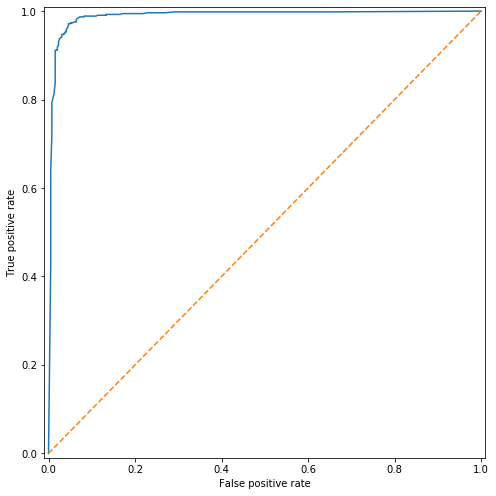

In [235]:
probs = C.predict_proba(spam_X_test)
rows, cols = probs.shape
probs_dicts = [{j: probs[i, j] for j in range(cols)}for i in range(rows)]
plot_roc_curve(spam_y_test, probs_dicts)

In [237]:
%%time
C.fit(cancer_X_train, cancer_y_train)

Learning rate set to 0.00736
0:	learn: 0.6812692	total: 9.23ms	remaining: 9.22s
1:	learn: 0.6692551	total: 16.2ms	remaining: 8.06s
2:	learn: 0.6584064	total: 22.9ms	remaining: 7.61s
3:	learn: 0.6482301	total: 30.1ms	remaining: 7.5s
4:	learn: 0.6375533	total: 37.4ms	remaining: 7.45s
5:	learn: 0.6284459	total: 45.4ms	remaining: 7.53s
6:	learn: 0.6166395	total: 57.3ms	remaining: 8.12s
7:	learn: 0.6065143	total: 64.6ms	remaining: 8.01s
8:	learn: 0.5956138	total: 71.6ms	remaining: 7.88s
9:	learn: 0.5863199	total: 77.2ms	remaining: 7.64s
10:	learn: 0.5759723	total: 86ms	remaining: 7.73s
11:	learn: 0.5666277	total: 91.8ms	remaining: 7.56s
12:	learn: 0.5565833	total: 97.5ms	remaining: 7.4s
13:	learn: 0.5481102	total: 103ms	remaining: 7.27s
14:	learn: 0.5396832	total: 109ms	remaining: 7.15s
15:	learn: 0.5312289	total: 115ms	remaining: 7.05s
16:	learn: 0.5238478	total: 120ms	remaining: 6.96s
17:	learn: 0.5156343	total: 126ms	remaining: 6.87s
18:	learn: 0.5084475	total: 132ms	remaining: 6.8s
19:	

173:	learn: 0.1015820	total: 1.2s	remaining: 5.68s
174:	learn: 0.1010343	total: 1.21s	remaining: 5.71s
175:	learn: 0.1002121	total: 1.22s	remaining: 5.72s
176:	learn: 0.0995819	total: 1.23s	remaining: 5.72s
177:	learn: 0.0988917	total: 1.24s	remaining: 5.71s
178:	learn: 0.0983106	total: 1.24s	remaining: 5.7s
179:	learn: 0.0977208	total: 1.25s	remaining: 5.69s
180:	learn: 0.0971656	total: 1.25s	remaining: 5.68s
181:	learn: 0.0967994	total: 1.26s	remaining: 5.67s
182:	learn: 0.0961938	total: 1.27s	remaining: 5.66s
183:	learn: 0.0954392	total: 1.27s	remaining: 5.64s
184:	learn: 0.0947548	total: 1.28s	remaining: 5.63s
185:	learn: 0.0941824	total: 1.28s	remaining: 5.62s
186:	learn: 0.0935923	total: 1.29s	remaining: 5.61s
187:	learn: 0.0931124	total: 1.29s	remaining: 5.59s
188:	learn: 0.0925652	total: 1.3s	remaining: 5.58s
189:	learn: 0.0917966	total: 1.31s	remaining: 5.57s
190:	learn: 0.0910917	total: 1.31s	remaining: 5.56s
191:	learn: 0.0906503	total: 1.32s	remaining: 5.55s
192:	learn: 0.0

354:	learn: 0.0427381	total: 2.39s	remaining: 4.34s
355:	learn: 0.0425271	total: 2.4s	remaining: 4.34s
356:	learn: 0.0423753	total: 2.4s	remaining: 4.33s
357:	learn: 0.0422254	total: 2.42s	remaining: 4.34s
358:	learn: 0.0420649	total: 2.43s	remaining: 4.33s
359:	learn: 0.0419702	total: 2.43s	remaining: 4.33s
360:	learn: 0.0418754	total: 2.44s	remaining: 4.32s
361:	learn: 0.0417421	total: 2.45s	remaining: 4.31s
362:	learn: 0.0415945	total: 2.45s	remaining: 4.3s
363:	learn: 0.0414427	total: 2.46s	remaining: 4.29s
364:	learn: 0.0413377	total: 2.46s	remaining: 4.29s
365:	learn: 0.0411747	total: 2.47s	remaining: 4.28s
366:	learn: 0.0410283	total: 2.48s	remaining: 4.27s
367:	learn: 0.0408589	total: 2.48s	remaining: 4.27s
368:	learn: 0.0407519	total: 2.49s	remaining: 4.26s
369:	learn: 0.0405879	total: 2.5s	remaining: 4.25s
370:	learn: 0.0404091	total: 2.51s	remaining: 4.25s
371:	learn: 0.0402743	total: 2.51s	remaining: 4.24s
372:	learn: 0.0401369	total: 2.52s	remaining: 4.23s
373:	learn: 0.04

517:	learn: 0.0258389	total: 3.62s	remaining: 3.36s
518:	learn: 0.0257827	total: 3.62s	remaining: 3.36s
519:	learn: 0.0256995	total: 3.63s	remaining: 3.35s
520:	learn: 0.0256145	total: 3.64s	remaining: 3.34s
521:	learn: 0.0255488	total: 3.64s	remaining: 3.34s
522:	learn: 0.0254773	total: 3.65s	remaining: 3.33s
523:	learn: 0.0254369	total: 3.66s	remaining: 3.32s
524:	learn: 0.0253582	total: 3.67s	remaining: 3.32s
525:	learn: 0.0252831	total: 3.67s	remaining: 3.31s
526:	learn: 0.0252173	total: 3.69s	remaining: 3.31s
527:	learn: 0.0251400	total: 3.7s	remaining: 3.31s
528:	learn: 0.0250619	total: 3.71s	remaining: 3.3s
529:	learn: 0.0250180	total: 3.73s	remaining: 3.3s
530:	learn: 0.0249813	total: 3.74s	remaining: 3.3s
531:	learn: 0.0248874	total: 3.75s	remaining: 3.3s
532:	learn: 0.0248282	total: 3.76s	remaining: 3.29s
533:	learn: 0.0247762	total: 3.77s	remaining: 3.29s
534:	learn: 0.0247053	total: 3.78s	remaining: 3.29s
535:	learn: 0.0246467	total: 3.79s	remaining: 3.28s
536:	learn: 0.024

703:	learn: 0.0162037	total: 5.03s	remaining: 2.11s
704:	learn: 0.0161581	total: 5.04s	remaining: 2.11s
705:	learn: 0.0161148	total: 5.05s	remaining: 2.1s
706:	learn: 0.0160775	total: 5.06s	remaining: 2.1s
707:	learn: 0.0160474	total: 5.07s	remaining: 2.09s
708:	learn: 0.0160165	total: 5.08s	remaining: 2.08s
709:	learn: 0.0159664	total: 5.08s	remaining: 2.08s
710:	learn: 0.0159290	total: 5.09s	remaining: 2.07s
711:	learn: 0.0159037	total: 5.09s	remaining: 2.06s
712:	learn: 0.0158679	total: 5.1s	remaining: 2.05s
713:	learn: 0.0158283	total: 5.11s	remaining: 2.05s
714:	learn: 0.0158026	total: 5.12s	remaining: 2.04s
715:	learn: 0.0157675	total: 5.13s	remaining: 2.03s
716:	learn: 0.0157376	total: 5.14s	remaining: 2.03s
717:	learn: 0.0157104	total: 5.14s	remaining: 2.02s
718:	learn: 0.0156683	total: 5.16s	remaining: 2.02s
719:	learn: 0.0156467	total: 5.17s	remaining: 2.01s
720:	learn: 0.0156089	total: 5.18s	remaining: 2s
721:	learn: 0.0155803	total: 5.19s	remaining: 2s
722:	learn: 0.0155484

877:	learn: 0.0113886	total: 6.22s	remaining: 865ms
878:	learn: 0.0113734	total: 6.25s	remaining: 860ms
879:	learn: 0.0113530	total: 6.26s	remaining: 853ms
880:	learn: 0.0113277	total: 6.27s	remaining: 847ms
881:	learn: 0.0113117	total: 6.27s	remaining: 839ms
882:	learn: 0.0112907	total: 6.28s	remaining: 833ms
883:	learn: 0.0112764	total: 6.29s	remaining: 825ms
884:	learn: 0.0112502	total: 6.3s	remaining: 819ms
885:	learn: 0.0112296	total: 6.31s	remaining: 811ms
886:	learn: 0.0112051	total: 6.31s	remaining: 804ms
887:	learn: 0.0111759	total: 6.32s	remaining: 797ms
888:	learn: 0.0111476	total: 6.33s	remaining: 790ms
889:	learn: 0.0111216	total: 6.33s	remaining: 783ms
890:	learn: 0.0110930	total: 6.34s	remaining: 775ms
891:	learn: 0.0110747	total: 6.34s	remaining: 768ms
892:	learn: 0.0110588	total: 6.35s	remaining: 761ms
893:	learn: 0.0110349	total: 6.35s	remaining: 753ms
894:	learn: 0.0110085	total: 6.36s	remaining: 746ms
895:	learn: 0.0109825	total: 6.37s	remaining: 739ms
896:	learn: 0

In [238]:
C_y_pred = C.predict(cancer_X_test)
print(f'Accuracy: {accuracy_score(cancer_y_test, C_y_pred):.2f}')
print(f'AUC: {roc_auc_score(cancer_y_test, C_y_pred):.2f}')

Accuracy: 0.97
AUC: 0.97


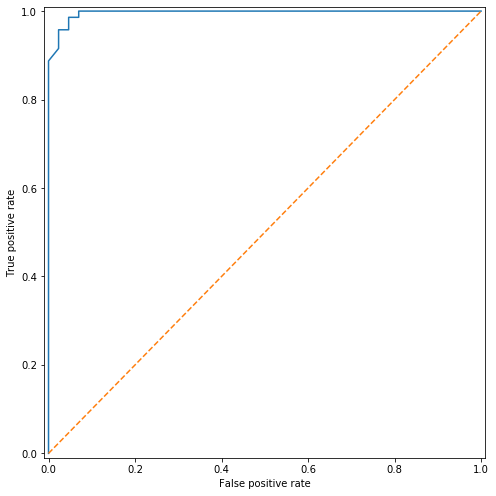

In [239]:
probs = C.predict_proba(cancer_X_test)
rows, cols = probs.shape
probs_dicts = [{j: probs[i, j] for j in range(cols)}for i in range(rows)]
plot_roc_curve(cancer_y_test, probs_dicts)

# xgboost

In [241]:
dtrain = xgboost.DMatrix(cancer_X_train, label=cancer_y_train)
dtest = xgboost.DMatrix(cancer_X_test, label=cancer_y_test)

In [243]:
param = {'max_depth':5, 'eta':1, 'objective':'binary:logistic' }

In [245]:
%%time
bst = xgboost.train(param, dtrain)

[00:17:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 309 ms, sys: 8.01 ms, total: 317 ms
Wall time: 113 ms


In [260]:
X_y_prob = bst.predict(dtest)
X_y_pred = np.zeros(len(X_y_prob))
X_y_pred[X_y_prob > 0.5] = 1
print(f'Accuracy: {accuracy_score(cancer_y_test, X_y_pred):.2f}')
print(f'AUC: {roc_auc_score(cancer_y_test, X_y_pred):.2f}')

Accuracy: 0.95
AUC: 0.94


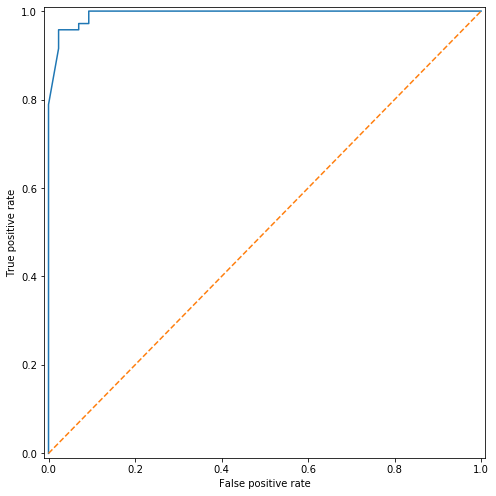

In [261]:
probs_dicts = [{0: 1-p, 1: p} for p in X_y_prob]
plot_roc_curve(cancer_y_test, probs_dicts)

In [262]:
dtrain = xgboost.DMatrix(spam_X_train, label=spam_y_train)
dtest = xgboost.DMatrix(spam_X_test, label=spam_y_test)

In [263]:
%%time
bst = xgboost.train(param, dtrain)

[00:25:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 497 ms, sys: 34 µs, total: 497 ms
Wall time: 162 ms


In [264]:
X_y_prob = bst.predict(dtest)
X_y_pred = np.zeros(len(X_y_prob))
X_y_pred[X_y_prob > 0.5] = 1
print(f'Accuracy: {accuracy_score(spam_y_test, X_y_pred):.2f}')
print(f'AUC: {roc_auc_score(spam_y_test, X_y_pred):.2f}')

Accuracy: 0.95
AUC: 0.94


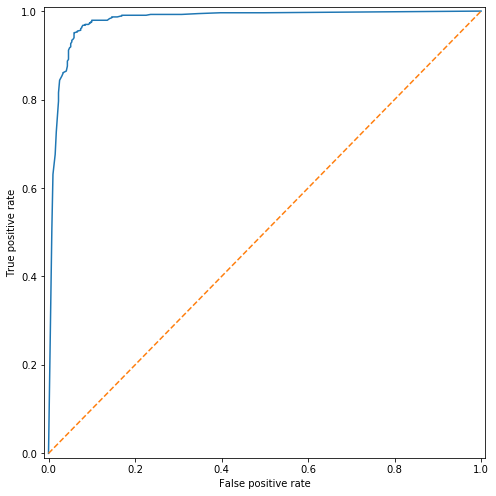

In [265]:
probs_dicts = [{0: 1-p, 1: p} for p in X_y_prob]
plot_roc_curve(spam_y_test, probs_dicts)

# Вывод

1. Моя реализация деревьев и леса работает ужасно медленно, но даже с ней можно добиться высокой точности.
2. Всё, что уже написано в библиотеках, лучше использовать, а не писать заново, потому что скорее всего оно работает быстро и хорошо.
3. Даже с дефолтными параметрами из коробки эти методы показывают очень высокую точность на используемых датасетах.